<a href="https://colab.research.google.com/github/ancestor9/Affalatoxin-Analysis/blob/main/affolatoxin_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== 기후 기반 아플라톡신 발생위험 예측 분석 ===

1. 데이터 생성...
생성된 데이터: 100개 샘플
데이터 기간: 2022-01-01 00:00:00 ~ 2030-04-01 00:00:00
지역: ['A' 'B' 'C']

훈련 데이터: 80개
테스트 데이터: 20개

2. 모델 학습 및 예측...
ARIMA 모델 학습 중...
SARIMAX 모델 학습 중...
머신러닝 모델 학습 중...
딥러닝 모델 학습 중...

3. 모델 성능 평가...

=== 모델 성능 결과 ===
ARIMA:
  RMSE: 1.195
  MAE: 1.01
  R²: -0.023

SARIMAX:
  RMSE: 1.662
  MAE: 1.3
  R²: -0.98

Machine Learning:
  RMSE: 1.395
  MAE: 1.163
  R²: -0.395

Deep Learning:
  RMSE: 1.137
  MAE: 0.995
  R²: 0.074

4. 결과 시각화...


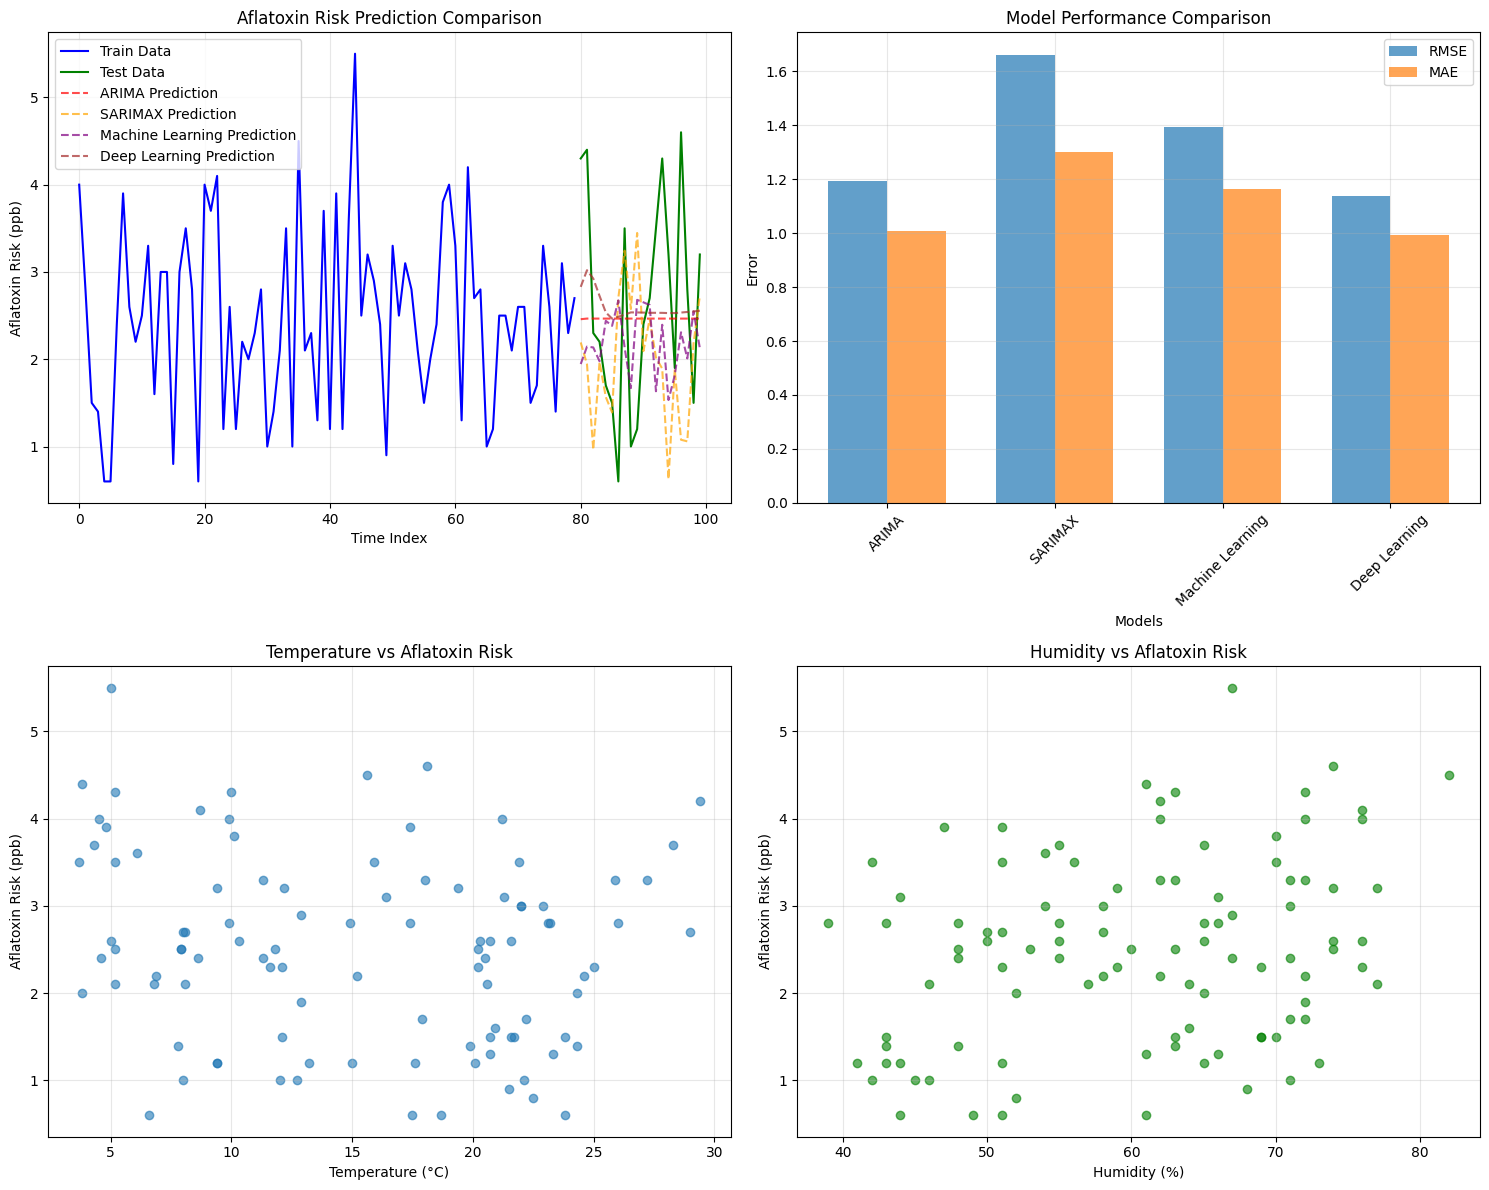

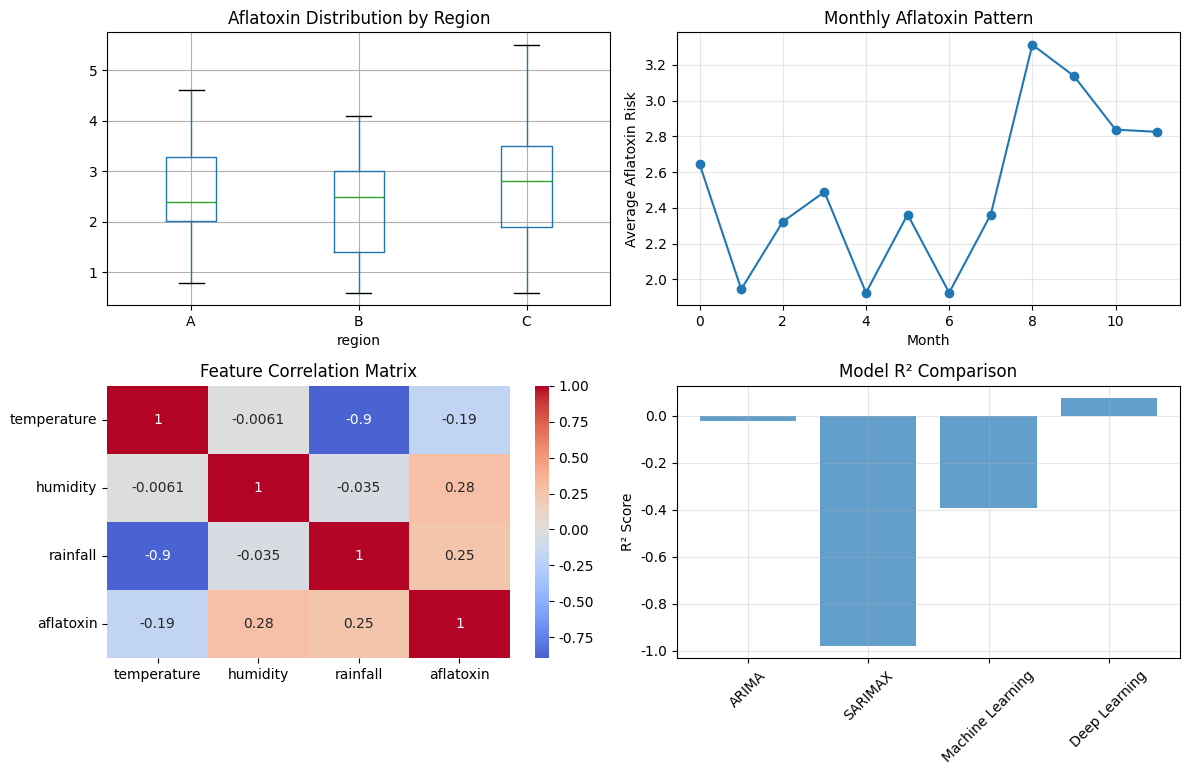


=== 데이터 요약 통계 ===
       temperature    humidity    rainfall   aflatoxin
count    100.00000  100.000000  100.000000  100.000000
mean      15.29800   60.280000   49.040000    2.501000
std        7.20603   10.784463   30.636982    1.074826
min        3.70000   39.000000    0.000000    0.600000
25%        8.67500   51.000000   21.750000    1.500000
50%       15.75000   62.000000   45.500000    2.500000
75%       21.52500   70.000000   77.250000    3.225000
max       29.40000   82.000000  106.000000    5.500000

=== 분석 완료 ===
모든 모델의 학습, 예측, 평가 및 시각화가 완료되었습니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

class AflatoxinPredictionModels:
    def __init__(self):
        self.data = None
        self.models = {}
        self.predictions = {}
        self.metrics = {}

    def generate_data(self, n_samples=100):
        """가상 기후 데이터 생성"""
        np.random.seed(42)

        regions = ['A', 'B', 'C']
        data = []

        for i in range(n_samples):
            month = (i % 12) + 1
            year = 2022 + i // 12
            region = regions[i % len(regions)]

            # 계절성과 트렌드가 있는 기후 데이터 생성
            seasonal_temp = 15 + 10 * np.sin(2 * np.pi * month / 12)
            seasonal_humidity = 60 + 15 * np.sin(2 * np.pi * (month + 3) / 12)
            seasonal_rainfall = 50 + 40 * np.sin(2 * np.pi * (month + 6) / 12)

            temperature = seasonal_temp + np.random.normal(0, 2.5)
            humidity = np.clip(seasonal_humidity + np.random.normal(0, 5), 30, 90)
            rainfall = np.clip(seasonal_rainfall + np.random.normal(0, 10), 0, 200)

            # 아플라톡신 위험도 계산
            temp_risk = max(0, (temperature - 25) * 0.3)
            humidity_risk = max(0, (humidity - 70) * 0.2)
            rainfall_risk = max(0, (rainfall - 80) * 0.1)

            aflatoxin_risk = np.clip(
                2 + temp_risk + humidity_risk + rainfall_risk + np.random.normal(0, 1),
                0, 15
            )

            data.append({
                'date': f'{year}-{month:02d}',
                'region': region,
                'temperature': round(temperature, 1),
                'rainfall': round(rainfall, 0),
                'humidity': round(humidity, 0),
                'aflatoxin': round(aflatoxin_risk, 1),
                'time_index': i
            })

        self.data = pd.DataFrame(data)
        self.data['date'] = pd.to_datetime(self.data['date'])
        return self.data

    def arima_model(self, train_data, forecast_steps=12):
        """ARIMA 모델"""
        print("ARIMA 모델 학습 중...")

        # 시계열 데이터 준비
        ts_data = train_data.set_index('date')['aflatoxin']
        ts_data = ts_data.asfreq('MS')  # 월별 주기 설정

        try:
            # ARIMA 모델 훈련
            model = ARIMA(ts_data, order=(1, 1, 1))
            fitted_model = model.fit()

            # 예측
            forecast = fitted_model.forecast(steps=forecast_steps)
            forecast_values = np.maximum(0, forecast.values)

            self.models['ARIMA'] = fitted_model
            return forecast_values

        except Exception as e:
            print(f"ARIMA 모델 오류: {e}")
            # 단순 예측으로 대체
            last_value = ts_data.iloc[-1]
            trend = ts_data.diff().tail(5).mean()
            return np.maximum(0, [last_value + trend * (i+1) for i in range(forecast_steps)])

    def sarimax_model(self, train_data, forecast_steps=12):
        """SARIMAX 모델"""
        print("SARIMAX 모델 학습 중...")

        # 시계열 데이터와 외생변수 준비
        ts_data = train_data.set_index('date')
        endog = ts_data['aflatoxin'].asfreq('MS')
        exog = ts_data[['temperature', 'humidity', 'rainfall']].asfreq('MS')

        try:
            # SARIMAX 모델 훈련
            model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            fitted_model = model.fit(disp=False)

            # 미래 외생변수 생성 (마지막 값 기준으로 약간의 변동)
            last_exog = exog.iloc[-1]
            future_exog = []
            for i in range(forecast_steps):
                future_temp = last_exog['temperature'] + np.random.normal(0, 1)
                future_humidity = last_exog['humidity'] + np.random.normal(0, 2)
                future_rainfall = last_exog['rainfall'] + np.random.normal(0, 5)
                future_exog.append([future_temp, future_humidity, future_rainfall])

            future_exog = pd.DataFrame(future_exog, columns=['temperature', 'humidity', 'rainfall'])

            # 예측
            forecast = fitted_model.forecast(steps=forecast_steps, exog=future_exog)
            forecast_values = np.maximum(0, forecast.values)

            self.models['SARIMAX'] = fitted_model
            return forecast_values

        except Exception as e:
            print(f"SARIMAX 모델 오류: {e}")
            # 계절성을 고려한 단순 예측
            seasonal_pattern = []
            for i in range(forecast_steps):
                month_idx = (len(train_data) + i) % 12
                historical_month = train_data[train_data['time_index'] % 12 == month_idx]['aflatoxin']
                if len(historical_month) > 0:
                    seasonal_avg = historical_month.mean()
                else:
                    seasonal_avg = train_data['aflatoxin'].mean()
                seasonal_pattern.append(seasonal_avg)
            return np.array(seasonal_pattern)

    def machine_learning_model(self, train_data, forecast_steps=12):
        """머신러닝 모델 (Random Forest)"""
        print("머신러닝 모델 학습 중...")

        # 특성 및 타겟 준비
        features = ['temperature', 'humidity', 'rainfall']

        # 계절성 특성 추가
        train_data['month'] = train_data['time_index'] % 12
        train_data['season_sin'] = np.sin(2 * np.pi * train_data['month'] / 12)
        train_data['season_cos'] = np.cos(2 * np.pi * train_data['month'] / 12)

        feature_cols = features + ['season_sin', 'season_cos']
        X_train = train_data[feature_cols]
        y_train = train_data['aflatoxin']

        # 모델 훈련
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # 미래 예측을 위한 데이터 생성
        last_data = train_data.iloc[-1]
        future_predictions = []

        for i in range(forecast_steps):
            future_month = (last_data['time_index'] + i + 1) % 12
            future_features = {
                'temperature': last_data['temperature'] + np.random.normal(0, 1),
                'humidity': last_data['humidity'] + np.random.normal(0, 2),
                'rainfall': last_data['rainfall'] + np.random.normal(0, 5),
                'season_sin': np.sin(2 * np.pi * future_month / 12),
                'season_cos': np.cos(2 * np.pi * future_month / 12)
            }

            X_future = pd.DataFrame([future_features])
            prediction = model.predict(X_future)[0]
            future_predictions.append(max(0, prediction))

        self.models['MachineLearning'] = model
        return np.array(future_predictions)

    def deep_learning_model(self, train_data, forecast_steps=12):
        """딥러닝 모델 (LSTM)"""
        print("딥러닝 모델 학습 중...")

        # 시계열 데이터 준비
        sequence_length = 10
        features = ['temperature', 'humidity', 'rainfall', 'aflatoxin']

        # 데이터 정규화
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(train_data[features])

        # 시퀀스 데이터 생성
        X, y = [], []
        for i in range(sequence_length, len(scaled_data)):
            X.append(scaled_data[i-sequence_length:i, :3])  # 기후 변수만 입력
            y.append(scaled_data[i, 3])  # 아플라톡신 농도가 타겟

        X, y = np.array(X), np.array(y)

        # LSTM 모델 구성
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(sequence_length, 3)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        # 모델 훈련
        model.fit(X, y, epochs=50, batch_size=32, verbose=0)

        # 예측
        last_sequence = scaled_data[-sequence_length:, :3]
        predictions = []

        for _ in range(forecast_steps):
            pred = model.predict(last_sequence.reshape(1, sequence_length, 3), verbose=0)
            predictions.append(pred[0, 0])

            # 다음 시퀀스를 위해 예측값으로 업데이트
            new_features = np.array([[
                last_sequence[-1, 0] + np.random.normal(0, 0.1),
                last_sequence[-1, 1] + np.random.normal(0, 0.1),
                last_sequence[-1, 2] + np.random.normal(0, 0.1)
            ]])

            last_sequence = np.vstack([last_sequence[1:], new_features])

        # 역정규화
        predictions = np.array(predictions)
        dummy_data = np.zeros((len(predictions), len(features)))
        dummy_data[:, 3] = predictions
        denormalized = scaler.inverse_transform(dummy_data)

        self.models['DeepLearning'] = {'model': model, 'scaler': scaler}
        return np.maximum(0, denormalized[:, 3])

    def evaluate_models(self, train_data, test_data, predictions):
        """모델 성능 평가"""
        test_actual = test_data['aflatoxin'].values

        for model_name, pred in predictions.items():
            if len(pred) >= len(test_actual):
                pred_trimmed = pred[:len(test_actual)]

                rmse = np.sqrt(mean_squared_error(test_actual, pred_trimmed))
                mae = mean_absolute_error(test_actual, pred_trimmed)
                r2 = r2_score(test_actual, pred_trimmed)

                self.metrics[model_name] = {
                    'RMSE': round(rmse, 3),
                    'MAE': round(mae, 3),
                    'R2': round(r2, 3)
                }

    def visualize_results(self):
        """결과 시각화"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. 시계열 예측 결과
        ax1 = axes[0, 0]
        train_size = int(len(self.data) * 0.8)
        train_data = self.data[:train_size]
        test_data = self.data[train_size:]

        ax1.plot(train_data.index, train_data['aflatoxin'], label='Train Data', color='blue')
        ax1.plot(test_data.index, test_data['aflatoxin'], label='Test Data', color='green')

        colors = ['red', 'orange', 'purple', 'brown']
        for i, (model_name, pred) in enumerate(self.predictions.items()):
            test_indices = test_data.index[:len(pred)]
            ax1.plot(test_indices, pred, label=f'{model_name} Prediction',
                    color=colors[i], linestyle='--', alpha=0.7)

        ax1.set_title('Aflatoxin Risk Prediction Comparison')
        ax1.set_xlabel('Time Index')
        ax1.set_ylabel('Aflatoxin Risk (ppb)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. 모델 성능 비교
        ax2 = axes[0, 1]
        models = list(self.metrics.keys())
        rmse_values = [self.metrics[m]['RMSE'] for m in models]
        mae_values = [self.metrics[m]['MAE'] for m in models]

        x = np.arange(len(models))
        width = 0.35

        ax2.bar(x - width/2, rmse_values, width, label='RMSE', alpha=0.7)
        ax2.bar(x + width/2, mae_values, width, label='MAE', alpha=0.7)
        ax2.set_title('Model Performance Comparison')
        ax2.set_xlabel('Models')
        ax2.set_ylabel('Error')
        ax2.set_xticks(x)
        ax2.set_xticklabels(models, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. 기온 vs 아플라톡신 상관관계
        ax3 = axes[1, 0]
        ax3.scatter(self.data['temperature'], self.data['aflatoxin'], alpha=0.6)
        ax3.set_title('Temperature vs Aflatoxin Risk')
        ax3.set_xlabel('Temperature (°C)')
        ax3.set_ylabel('Aflatoxin Risk (ppb)')
        ax3.grid(True, alpha=0.3)

        # 4. 습도 vs 아플라톡신 상관관계
        ax4 = axes[1, 1]
        ax4.scatter(self.data['humidity'], self.data['aflatoxin'], alpha=0.6, color='green')
        ax4.set_title('Humidity vs Aflatoxin Risk')
        ax4.set_xlabel('Humidity (%)')
        ax4.set_ylabel('Aflatoxin Risk (ppb)')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 추가 시각화: 지역별 분석
        plt.figure(figsize=(12, 8))

        # 지역별 아플라톡신 분포
        plt.subplot(2, 2, 1)
        self.data.boxplot(column='aflatoxin', by='region', ax=plt.gca())
        plt.title('Aflatoxin Distribution by Region')
        plt.suptitle('')

        # 월별 패턴
        plt.subplot(2, 2, 2)
        monthly_data = self.data.groupby(self.data['time_index'] % 12)['aflatoxin'].mean()
        plt.plot(range(12), monthly_data.values, marker='o')
        plt.title('Monthly Aflatoxin Pattern')
        plt.xlabel('Month')
        plt.ylabel('Average Aflatoxin Risk')
        plt.grid(True, alpha=0.3)

        # 상관관계 히트맵
        plt.subplot(2, 2, 3)
        correlation_matrix = self.data[['temperature', 'humidity', 'rainfall', 'aflatoxin']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')

        # 예측 정확도 비교
        plt.subplot(2, 2, 4)
        models = list(self.metrics.keys())
        r2_values = [self.metrics[m]['R2'] for m in models]
        plt.bar(models, r2_values, alpha=0.7)
        plt.title('Model R² Comparison')
        plt.ylabel('R² Score')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def run_analysis(self):
        """전체 분석 실행"""
        print("=== 기후 기반 아플라톡신 발생위험 예측 분석 ===\n")

        # 1. 데이터 생성
        print("1. 데이터 생성...")
        self.generate_data()
        print(f"생성된 데이터: {len(self.data)}개 샘플")
        print(f"데이터 기간: {self.data['date'].min()} ~ {self.data['date'].max()}")
        print(f"지역: {self.data['region'].unique()}")
        print()

        # 2. 데이터 분할
        train_size = int(len(self.data) * 0.8)
        train_data = self.data[:train_size]
        test_data = self.data[train_size:]

        print(f"훈련 데이터: {len(train_data)}개")
        print(f"테스트 데이터: {len(test_data)}개")
        print()

        # 3. 모델 학습 및 예측
        print("2. 모델 학습 및 예측...")

        # ARIMA
        arima_pred = self.arima_model(train_data, len(test_data))
        self.predictions['ARIMA'] = arima_pred

        # SARIMAX
        sarimax_pred = self.sarimax_model(train_data, len(test_data))
        self.predictions['SARIMAX'] = sarimax_pred

        # 머신러닝
        ml_pred = self.machine_learning_model(train_data, len(test_data))
        self.predictions['Machine Learning'] = ml_pred

        # 딥러닝
        dl_pred = self.deep_learning_model(train_data, len(test_data))
        self.predictions['Deep Learning'] = dl_pred

        print()

        # 4. 성능 평가
        print("3. 모델 성능 평가...")
        self.evaluate_models(train_data, test_data, self.predictions)

        print("\n=== 모델 성능 결과 ===")
        for model_name, metrics in self.metrics.items():
            print(f"{model_name}:")
            print(f"  RMSE: {metrics['RMSE']}")
            print(f"  MAE: {metrics['MAE']}")
            print(f"  R²: {metrics['R2']}")
            print()

        # 5. 결과 시각화
        print("4. 결과 시각화...")
        self.visualize_results()

        # 6. 데이터 요약 통계
        print("\n=== 데이터 요약 통계 ===")
        print(self.data[['temperature', 'humidity', 'rainfall', 'aflatoxin']].describe())

        return self.data, self.predictions, self.metrics

# 실행
if __name__ == "__main__":
    # 분석 실행
    analyzer = AflatoxinPredictionModels()
    data, predictions, metrics = analyzer.run_analysis()

    print("\n=== 분석 완료 ===")
    print("모든 모델의 학습, 예측, 평가 및 시각화가 완료되었습니다.")